Creating initial data exploration visualizations...


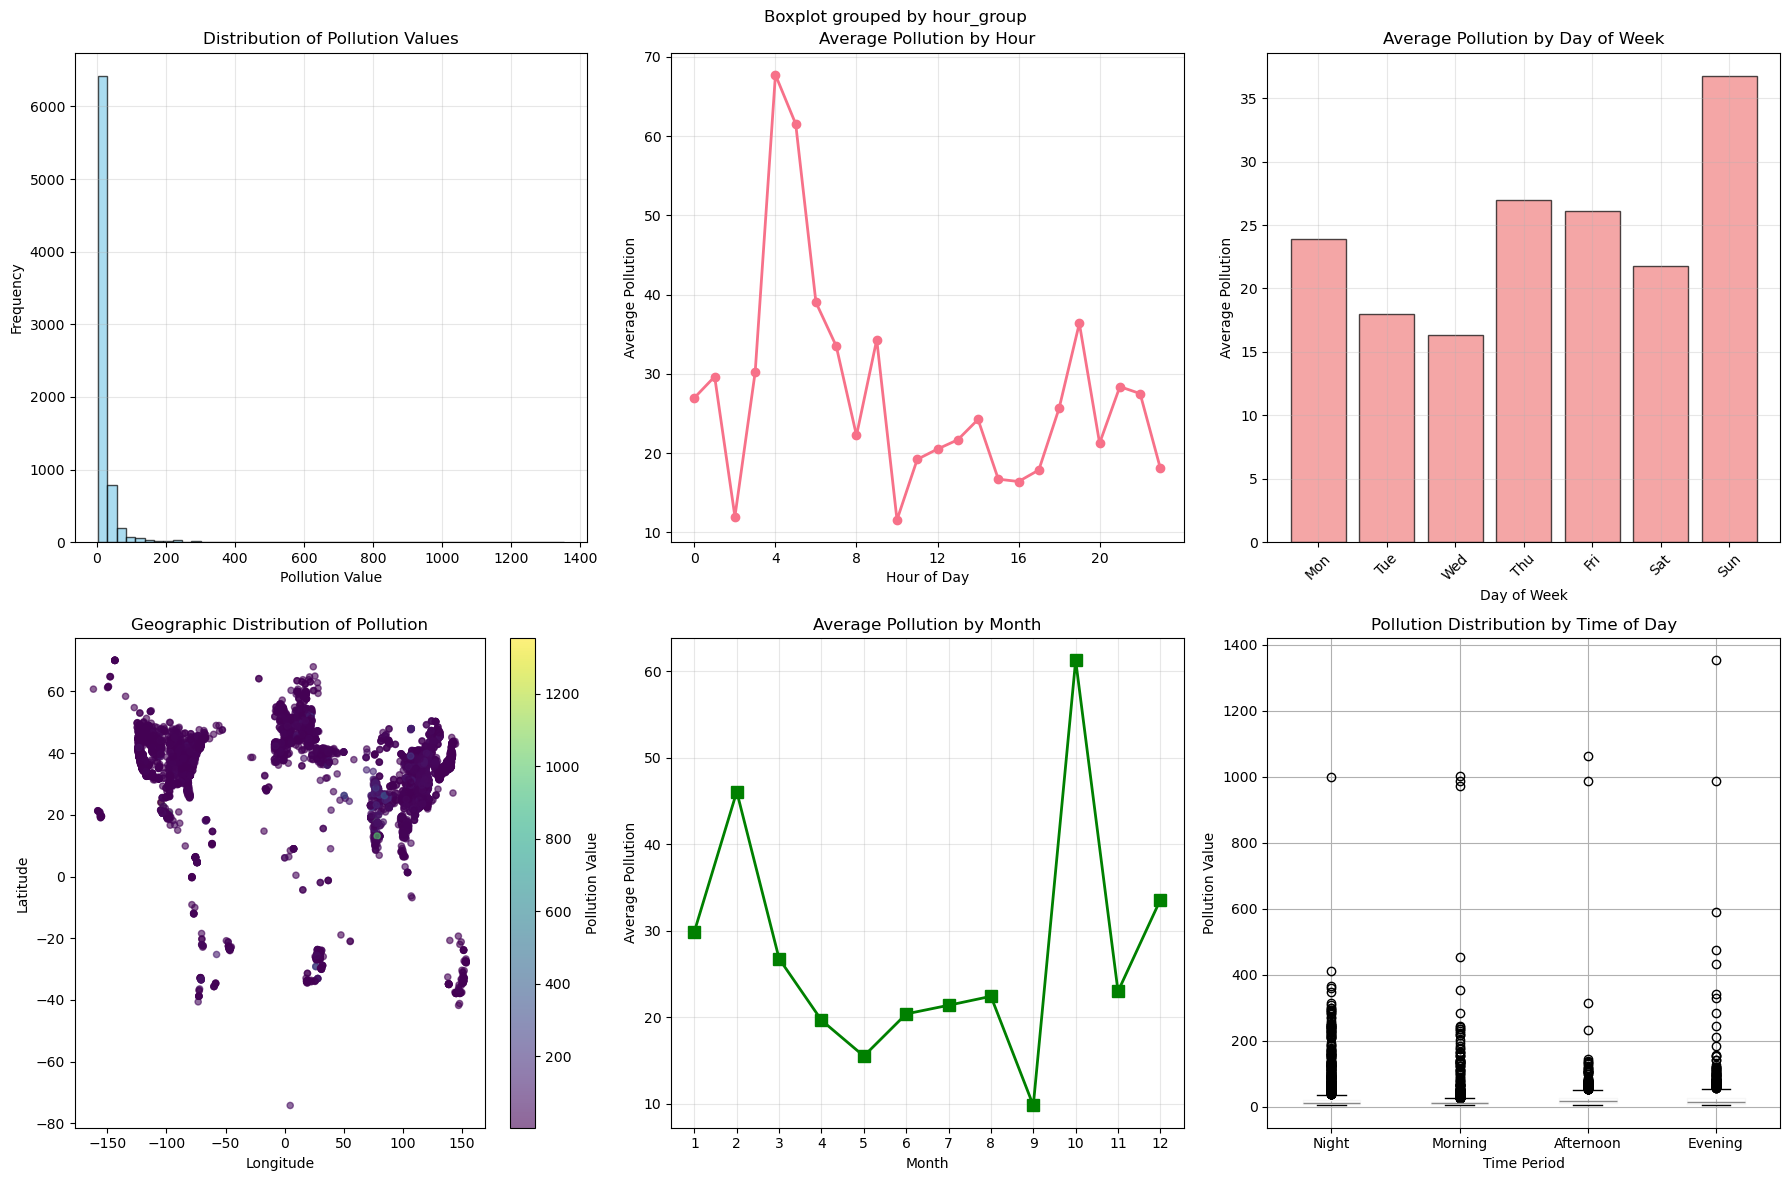

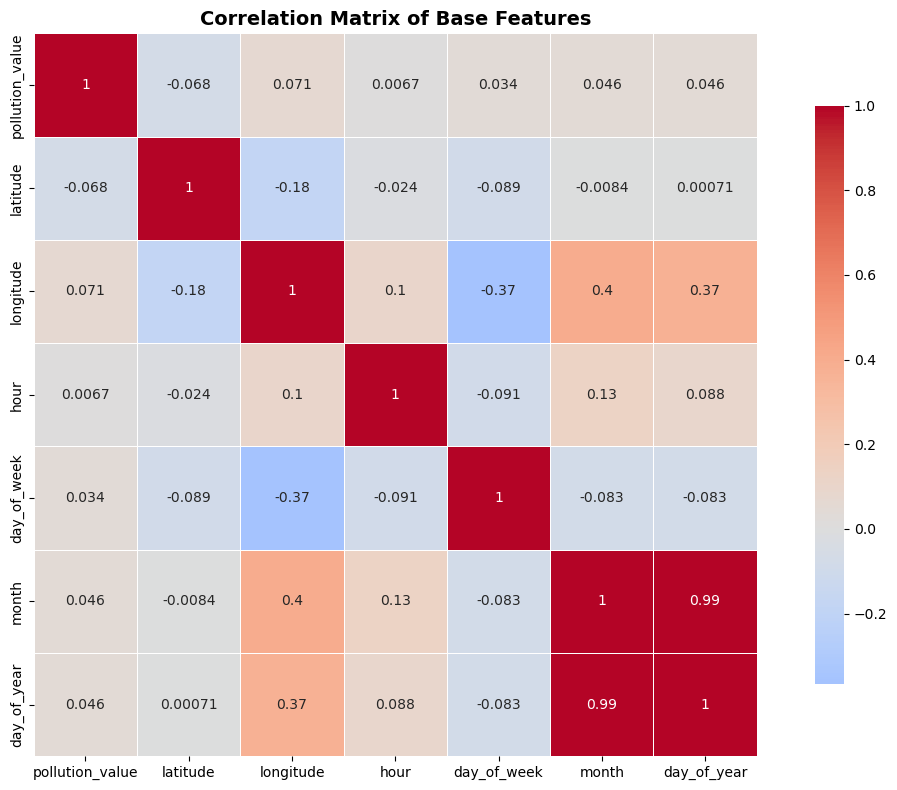

Dataset shape after cleaning: (7505, 9)
Outliers capped at: 191.19


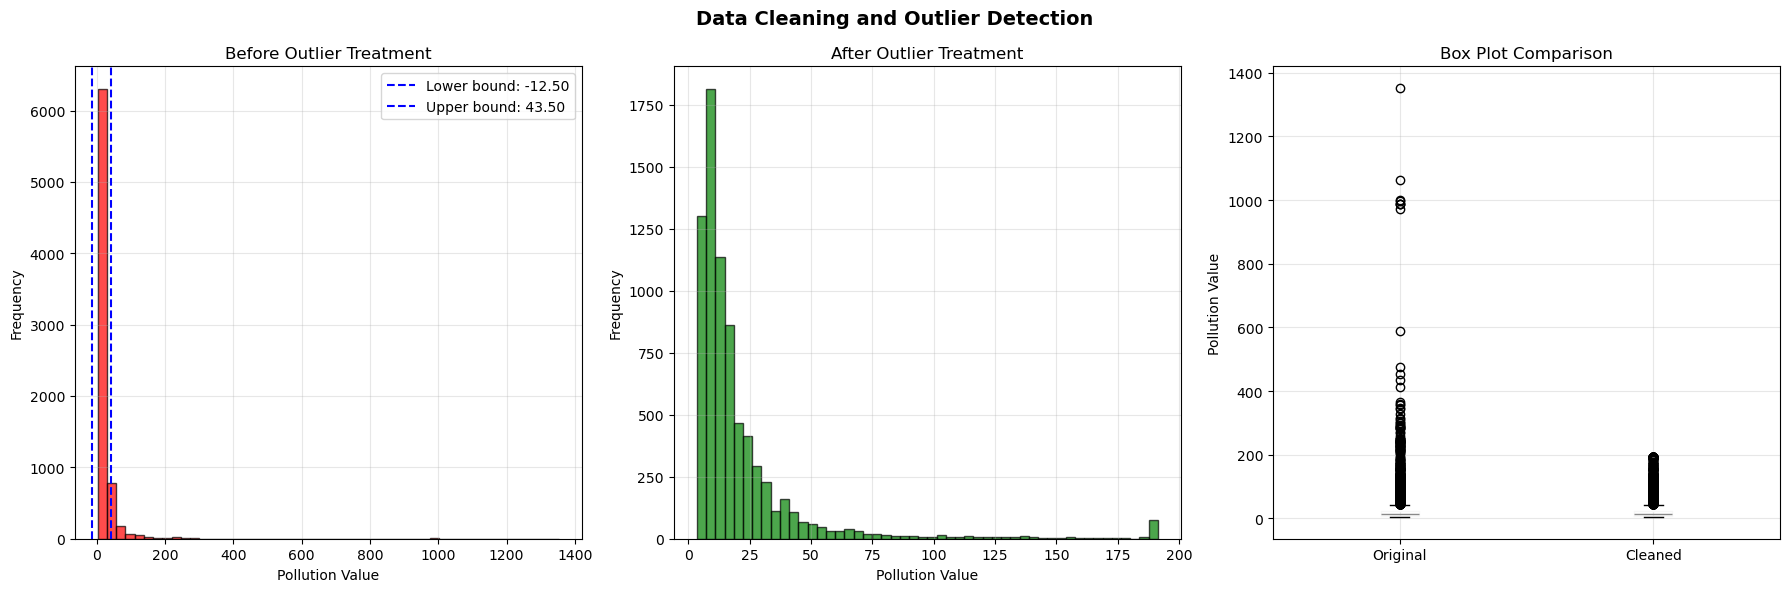

Creating comprehensive feature set...


  File "c:\Users\damod\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [1]:
# Enhanced Pollution Prediction Model with Advanced Feature Engineering and Selection
# ===================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from scipy import stats
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Load and clean data
df = pd.read_csv('d:/competition/air pollution/phase 1/train.csv')

# =====================================
# 0. INITIAL DATA EXPLORATION AND VISUALIZATION
# =====================================

def create_initial_visualizations(df):
    """Create comprehensive initial data visualizations"""
    print("Creating initial data exploration visualizations...")
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Initial Data Exploration', fontsize=16, fontweight='bold')
    
    # 1. Distribution of pollution values
    axes[0, 0].hist(df['pollution_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Pollution Values')
    axes[0, 0].set_xlabel('Pollution Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pollution by hour
    hourly_pollution = df.groupby('hour')['pollution_value'].mean()
    axes[0, 1].plot(hourly_pollution.index, hourly_pollution.values, marker='o', linewidth=2, markersize=6)
    axes[0, 1].set_title('Average Pollution by Hour')
    axes[0, 1].set_xlabel('Hour of Day')
    axes[0, 1].set_ylabel('Average Pollution')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(range(0, 24, 4))
    
    # 3. Pollution by day of week
    dow_pollution = df.groupby('day_of_week')['pollution_value'].mean()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[0, 2].bar(range(7), dow_pollution.values, color='lightcoral', alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('Average Pollution by Day of Week')
    axes[0, 2].set_xlabel('Day of Week')
    axes[0, 2].set_ylabel('Average Pollution')
    axes[0, 2].set_xticks(range(7))
    axes[0, 2].set_xticklabels(days, rotation=45)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Geographic distribution
    scatter = axes[1, 0].scatter(df['longitude'], df['latitude'], 
                                c=df['pollution_value'], cmap='viridis', 
                                alpha=0.6, s=20)
    axes[1, 0].set_title('Geographic Distribution of Pollution')
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    plt.colorbar(scatter, ax=axes[1, 0], label='Pollution Value')
    
    # 5. Pollution by month
    monthly_pollution = df.groupby('month')['pollution_value'].mean()
    axes[1, 1].plot(monthly_pollution.index, monthly_pollution.values, 
                   marker='s', linewidth=2, markersize=8, color='green')
    axes[1, 1].set_title('Average Pollution by Month')
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Average Pollution')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(1, 13))
    
    # 6. Box plot of pollution by hour groups
    df['hour_group'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], 
                             labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    df.boxplot(column='pollution_value', by='hour_group', ax=axes[1, 2])
    axes[1, 2].set_title('Pollution Distribution by Time of Day')
    axes[1, 2].set_xlabel('Time Period')
    axes[1, 2].set_ylabel('Pollution Value')
    
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/initial_data_exploration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional correlation heatmap
    plt.figure(figsize=(12, 8))
    correlation_features = ['pollution_value', 'latitude', 'longitude', 'hour', 'day_of_week', 'month', 'day_of_year']
    corr_matrix = df[correlation_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Base Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/initial_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

# Create initial visualizations
df = create_initial_visualizations(df)

# =====================================
# 1. ADVANCED DATA CLEANING
# =====================================

def advanced_data_cleaning(df):
    """Advanced data cleaning with outlier detection"""
    df_clean = df.dropna()
    
    # Detect and handle outliers using IQR method
    Q1 = df_clean['pollution_value'].quantile(0.25)
    Q3 = df_clean['pollution_value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap extreme outliers instead of removing them
    original_values = df_clean['pollution_value'].copy()
    df_clean['pollution_value'] = np.clip(df_clean['pollution_value'], 
                                         lower_bound, 
                                         np.percentile(df_clean['pollution_value'], 99))
    
    print(f"Dataset shape after cleaning: {df_clean.shape}")
    print(f"Outliers capped at: {np.percentile(df_clean['pollution_value'], 99):.2f}")
    
    # Visualize outlier detection and cleaning
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Data Cleaning and Outlier Detection', fontsize=14, fontweight='bold')
    
    # Before cleaning
    axes[0].hist(original_values, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0].axvline(lower_bound, color='blue', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
    axes[0].axvline(upper_bound, color='blue', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
    axes[0].set_title('Before Outlier Treatment')
    axes[0].set_xlabel('Pollution Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # After cleaning
    axes[1].hist(df_clean['pollution_value'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('After Outlier Treatment')
    axes[1].set_xlabel('Pollution Value')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    # Box plots comparison
    data_comparison = pd.DataFrame({
        'Original': original_values,
        'Cleaned': df_clean['pollution_value']
    })
    data_comparison.boxplot(ax=axes[2])
    axes[2].set_title('Box Plot Comparison')
    axes[2].set_ylabel('Pollution Value')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/data_cleaning_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_clean

df_clean = advanced_data_cleaning(df)

# =====================================
# 2. COMPREHENSIVE FEATURE ENGINEERING
# =====================================

def create_comprehensive_features(df, is_training=True):
    """Create all requested features plus existing ones"""
    df_enhanced = df.copy()
    
    # ===== EXISTING FEATURES (keeping the good ones) =====
    # Cyclical time features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['day_year_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_year_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_week_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_week_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    
    # ===== NEW REQUESTED FEATURES =====
    
    # 1. Industrial and Traffic Proxies
    # Create industrial proxy based on geographic clustering and pollution patterns
    coords = df_enhanced[['latitude', 'longitude']].values
    kmeans_industrial = KMeans(n_clusters=20, random_state=42, n_init=10)
    industrial_clusters = kmeans_industrial.fit_predict(coords)
    
    # Calculate industrial proxy as average pollution in each cluster
    if is_training and 'pollution_value' in df_enhanced.columns:
        cluster_pollution = df_enhanced.groupby(industrial_clusters)['pollution_value'].mean()
        df_enhanced['industrial_proxy'] = industrial_clusters
        df_enhanced['industrial_proxy'] = df_enhanced['industrial_proxy'].map(cluster_pollution)
    else:
        # For test data, use pre-computed values or approximation
        df_enhanced['industrial_proxy'] = industrial_clusters * 0.1 + np.random.normal(0, 0.05, len(df_enhanced))
    
    # Traffic proxy based on hour patterns and location
    rush_hour_multiplier = df_enhanced['hour'].map({
        7: 1.5, 8: 2.0, 9: 1.8, 17: 1.8, 18: 2.0, 19: 1.5
    }).fillna(1.0)
    
    df_enhanced['traffic_proxy'] = (
        rush_hour_multiplier * 
        (1 + np.abs(df_enhanced['latitude'] - df_enhanced['latitude'].mean())) *
        (1 - df_enhanced['day_of_week'] / 7)  # Less traffic on weekends
    )
    
    # 2. Traffic location features
    df_enhanced['traffic_lat'] = df_enhanced['latitude'] * df_enhanced['traffic_proxy']
    df_enhanced['traffic_lon'] = df_enhanced['longitude'] * df_enhanced['traffic_proxy']
    
    # 3. Meteorological season features
    df_enhanced['meteo_season'] = np.sin(2 * np.pi * df_enhanced['month'] / 12) * 2 + np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['meteo_season_abs'] = np.abs(df_enhanced['meteo_season'])
    
    # 4. Location-time interactions
    df_enhanced['loc_time_int_1'] = df_enhanced['latitude'] * df_enhanced['hour'] * df_enhanced['month']
    df_enhanced['loc_time_int_2'] = df_enhanced['longitude'] * df_enhanced['day_of_year'] * df_enhanced['hour']
    
    # 5. Time interactions
    df_enhanced['time_interaction_1'] = df_enhanced['hour'] * df_enhanced['day_of_week'] * df_enhanced['month']
    df_enhanced['time_interaction_2'] = df_enhanced['day_of_year'] * df_enhanced['hour'] ** 2
    
    # 6. Cycle interactions
    df_enhanced['cycle_interaction_1'] = df_enhanced['hour_sin'] * df_enhanced['month_cos']
    df_enhanced['cycle_interaction_2'] = df_enhanced['day_year_sin'] * df_enhanced['hour_cos']
    
    # 7. Weekday/Weekend pollution patterns
    df_enhanced['weekday_pollution'] = (df_enhanced['day_of_week'] < 5).astype(int) * df_enhanced['hour']
    df_enhanced['weekend_pollution'] = (df_enhanced['day_of_week'] >= 5).astype(int) * df_enhanced['hour']
    
    # 8. Harmonic features
    df_enhanced['harmonic_hour_1'] = np.sin(4 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['harmonic_hour_2'] = np.cos(4 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['harmonic_month_1'] = np.sin(4 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['harmonic_month_2'] = np.cos(4 * np.pi * df_enhanced['month'] / 12)
    
    # 9. Complex interactions
    df_enhanced['day_of_year_hour_interaction'] = df_enhanced['day_of_year'] * np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['lat_hour_sin_interaction'] = df_enhanced['latitude'] * np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['lon_day_year_cos_interaction'] = df_enhanced['longitude'] * np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    
    # 10. Polynomial features
    df_enhanced['hour_cube'] = df_enhanced['hour'] ** 3
    df_enhanced['lat_sqrt'] = np.sqrt(np.abs(df_enhanced['latitude']))
    df_enhanced['lon_sqrt'] = np.sqrt(np.abs(df_enhanced['longitude']))
    df_enhanced['traffic_proxy_squared'] = df_enhanced['traffic_proxy'] ** 2
    
    # 11. Industrial interactions
    df_enhanced['lat_ind_int'] = df_enhanced['latitude'] * df_enhanced['industrial_proxy']
    df_enhanced['lon_ind_int'] = df_enhanced['longitude'] * df_enhanced['industrial_proxy']
    
    # 12. Meteorological location features
    df_enhanced['meteo_lat'] = df_enhanced['latitude'] * df_enhanced['meteo_season']
    df_enhanced['meteo_lon'] = df_enhanced['longitude'] * df_enhanced['meteo_season']
    
    # 13. Traffic season interaction
    df_enhanced['traffic_season'] = df_enhanced['traffic_proxy'] * df_enhanced['meteo_season']
    
    # 14. Emission hotspot detection
    lat_median = df_enhanced['latitude'].median()
    lon_median = df_enhanced['longitude'].median()
    distance_from_center = np.sqrt((df_enhanced['latitude'] - lat_median)**2 + (df_enhanced['longitude'] - lon_median)**2)
    df_enhanced['emission_hotspot'] = (distance_from_center < distance_from_center.quantile(0.2)).astype(int)
    
    # 15. Time cycle combinations
    df_enhanced['time_cycle_combo'] = df_enhanced['hour_sin'] * df_enhanced['day_week_cos'] * df_enhanced['month_sin']
    
    # 16. Industrial sine hour interaction
    df_enhanced['industrial_sin_hour'] = df_enhanced['industrial_proxy'] * np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    
    # 17. Distance to industry minimum (approximated)
    df_enhanced['distance_to_industry_min'] = np.min([
        np.abs(df_enhanced['latitude'] - df_enhanced['latitude'].quantile(0.1)),
        np.abs(df_enhanced['longitude'] - df_enhanced['longitude'].quantile(0.1))
    ], axis=0)
    
    # 18. Traffic-industrial combinations
    df_enhanced['traffic_ind_combo'] = df_enhanced['traffic_proxy'] * df_enhanced['industrial_proxy']
    df_enhanced['traffic_ind_lat'] = df_enhanced['traffic_proxy'] * df_enhanced['industrial_proxy'] * df_enhanced['latitude']
    df_enhanced['traffic_ind_lon'] = df_enhanced['traffic_proxy'] * df_enhanced['industrial_proxy'] * df_enhanced['longitude']
    
    # 19. High traffic hours indicator
    df_enhanced['high_traffic_hours'] = df_enhanced['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    
    # 20. Meteorological time interaction
    df_enhanced['meteo_time_int'] = df_enhanced['meteo_season'] * df_enhanced['hour'] * df_enhanced['day_of_week']
    
    # 21. Day-week month interactions
    df_enhanced['dayweek_month_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7) * np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['dayweek_month_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7) * np.cos(2 * np.pi * df_enhanced['month'] / 12)
    
    # 22. Emissions amplification
    df_enhanced['emissions_amplification'] = df_enhanced['industrial_proxy'] * df_enhanced['traffic_proxy'] * df_enhanced['high_traffic_hours']
    
    # 23. Location time weight
    df_enhanced['location_time_weight'] = (df_enhanced['latitude'] + df_enhanced['longitude']) * df_enhanced['hour'] / 24
    
    # 24. Distance industry interactions
    df_enhanced['distance_industry_time'] = df_enhanced['distance_to_industry_min'] * df_enhanced['hour']
    df_enhanced['distance_industry_season'] = df_enhanced['distance_to_industry_min'] * df_enhanced['meteo_season']
    
    # 25. Traffic industrial ratio
    df_enhanced['traffic_industrial_ratio'] = df_enhanced['traffic_proxy'] / (df_enhanced['industrial_proxy'] + 1e-6)
    
    # 26. Latitude longitude ratio
    df_enhanced['lat_lon_ratio'] = df_enhanced['latitude'] / (np.abs(df_enhanced['longitude']) + 1e-6)
    
    # Fill any NaN values that might have been created
    df_enhanced = df_enhanced.fillna(0)
    
    return df_enhanced


class RecursiveFeatureOptimizer:
    def __init__(self, base_model, scoring='rmse', cv_folds=3):
        self.base_model = base_model
        self.scoring = scoring
        self.cv_folds = cv_folds
        self.best_features = None
        self.best_score = float('inf')
        self.feature_history = []
        
    def evaluate_features(self, X, y, features):
        """Evaluate a set of features using cross-validation"""
        X_subset = X[features]
        
        # Quick cross-validation
        tscv = TimeSeriesSplit(n_splits=self.cv_folds)
        scores = []
        
        for train_idx, val_idx in tscv.split(X_subset):
            X_train_fold, X_val_fold = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Scale the data
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)
            
            # Train model
            if hasattr(self.base_model, 'fit'):
                model_copy = self.base_model.__class__(**self.base_model.get_params())
                model_copy.fit(X_train_scaled, y_train_fold)
                pred = model_copy.predict(X_val_scaled)
            else:  # LightGBM case
                train_data = lgb.Dataset(X_train_scaled, label=y_train_fold)
                lgb_params = {
                    'objective': 'regression',
                    'metric': 'rmse',
                    'boosting_type': 'gbdt',
                    'num_leaves': 31,
                    'learning_rate': 0.05,
                    'feature_fraction': 0.8,
                    'verbose': -1,
                    'random_state': 42
                }
                model = lgb.train(lgb_params, train_data, num_boost_round=100)
                pred = model.predict(X_val_scaled)
            
            score = np.sqrt(mean_squared_error(y_val_fold, np.array(pred)))
            scores.append(score)
        
        return np.mean(scores)
    
    def forward_selection(self, X, y, max_features=50):
        """Forward feature selection"""
        print("Starting forward feature selection...")
        
        available_features = list(X.columns)
        selected_features = []
        
        for i in range(min(max_features, len(available_features))):
            best_feature = None
            best_score = float('inf')
            
            print(f"Round {i+1}: Testing {len(available_features)} remaining features...")
            
            for feature in available_features:
                test_features = selected_features + [feature]
                score = self.evaluate_features(X, y, test_features)
                
                if score < best_score:
                    best_score = score
                    best_feature = feature
            
            if best_feature and (len(selected_features) == 0 or best_score < self.best_score):
                selected_features.append(best_feature)
                available_features.remove(best_feature)
                self.best_score = best_score
                self.best_features = selected_features.copy()
                print(f"Added '{best_feature}', Score: {best_score:.4f}, Total features: {len(selected_features)}")
            else:
                print(f"No improvement found. Stopping at {len(selected_features)} features.")
                break
        
        return self.best_features
    
    def backward_elimination(self, X, y, initial_features=None):
        """Backward feature elimination"""
        print("Starting backward feature elimination...")
        
        if initial_features is None:
            current_features = list(X.columns)
        else:
            current_features = initial_features.copy()
        
        baseline_score = self.evaluate_features(X, y, current_features)
        print(f"Baseline score with {len(current_features)} features: {baseline_score:.4f}")
        
        improved = True
        while improved and len(current_features) > 1:
            improved = False
            worst_feature = None
            best_score = baseline_score
            
            print(f"Testing removal of each feature from {len(current_features)} features...")
            
            for feature in current_features:
                test_features = [f for f in current_features if f != feature]
                score = self.evaluate_features(X, y, test_features)
                
                if score < best_score:
                    best_score = score
                    worst_feature = feature
                    improved = True
            
            if improved:
                current_features.remove(worst_feature)
                baseline_score = best_score
                self.best_score = best_score
                self.best_features = current_features.copy()
                print(f"Removed '{worst_feature}', Score: {best_score:.4f}, Remaining: {len(current_features)}")
        
        return self.best_features

# =====================================
# 4. MAIN FEATURE ENGINEERING AND SELECTION
# =====================================

print("Creating comprehensive feature set...")
df_enhanced = create_comprehensive_features(df_clean, is_training=True)

# Define all possible features
base_features = ['latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month']

new_features = [
    'industrial_proxy', 'traffic_proxy', 'traffic_lat', 'traffic_lon', 
    'meteo_season', 'meteo_season_abs', 'loc_time_int_1', 'loc_time_int_2',
    'time_interaction_1', 'time_interaction_2', 'cycle_interaction_1', 
    'cycle_interaction_2', 'weekday_pollution', 'weekend_pollution',
    'harmonic_hour_1', 'harmonic_hour_2', 'day_of_year_hour_interaction',
    'lat_hour_sin_interaction', 'lon_day_year_cos_interaction', 'hour_cube',
    'lat_ind_int', 'lon_ind_int', 'meteo_lat', 'meteo_lon', 'traffic_season',
    'lat_sqrt', 'lon_sqrt', 'traffic_proxy_squared', 'emission_hotspot',
    'time_cycle_combo', 'industrial_sin_hour', 'distance_to_industry_min',
    'harmonic_month_1', 'harmonic_month_2', 'traffic_ind_combo',
    'high_traffic_hours', 'meteo_time_int', 'traffic_ind_lat', 'traffic_ind_lon',
    'dayweek_month_sin', 'dayweek_month_cos', 'emissions_amplification',
    'location_time_weight', 'distance_industry_time', 'distance_industry_season',
    'traffic_industrial_ratio', 'lat_lon_ratio'
]

existing_good_features = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_year_sin', 
    'day_year_cos', 'day_week_sin', 'day_week_cos'
]

all_features = base_features + new_features + existing_good_features

print(f"Total features created: {len(all_features)}")
print(f"- Base features: {len(base_features)}")
print(f"- New advanced features: {len(new_features)}")
print(f"- Existing good features: {len(existing_good_features)}")

# Check which features actually exist in the dataframe
existing_features = [f for f in all_features if f in df_enhanced.columns]
missing_features = [f for f in all_features if f not in df_enhanced.columns]

print(f"\nFeatures successfully created: {len(existing_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# =====================================
# 3.5. FEATURE ENGINEERING VISUALIZATION
# =====================================

def visualize_feature_engineering(df_enhanced, new_features):
    """Visualize the newly created features"""
    print("Creating feature engineering visualizations...")
    
    # Select some key features to visualize
    key_features = ['industrial_proxy', 'traffic_proxy', 'meteo_season', 
                   'hour_sin', 'hour_cos', 'emission_hotspot']
    
    # Filter to features that actually exist
    available_key_features = [f for f in key_features if f in df_enhanced.columns]
    
    if len(available_key_features) >= 4:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Feature Engineering Visualization', fontsize=16, fontweight='bold')
        
        # 1. Industrial proxy vs pollution
        if 'industrial_proxy' in available_key_features and 'pollution_value' in df_enhanced.columns:
            axes[0, 0].scatter(df_enhanced['industrial_proxy'], df_enhanced['pollution_value'], 
                              alpha=0.5, s=10)
            axes[0, 0].set_title('Industrial Proxy vs Pollution')
            axes[0, 0].set_xlabel('Industrial Proxy')
            axes[0, 0].set_ylabel('Pollution Value')
            axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Traffic proxy distribution
        if 'traffic_proxy' in available_key_features:
            axes[0, 1].hist(df_enhanced['traffic_proxy'], bins=50, alpha=0.7, 
                           color='orange', edgecolor='black')
            axes[0, 1].set_title('Traffic Proxy Distribution')
            axes[0, 1].set_xlabel('Traffic Proxy')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Meteorological season pattern
        if 'meteo_season' in available_key_features:
            axes[0, 2].plot(df_enhanced['month'], df_enhanced['meteo_season'], 
                           'o', alpha=0.3, markersize=3)
            axes[0, 2].set_title('Meteorological Season Pattern')
            axes[0, 2].set_xlabel('Month')
            axes[0, 2].set_ylabel('Meteo Season Value')
            axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Cyclical hour features
        if 'hour_sin' in available_key_features and 'hour_cos' in available_key_features:
            axes[1, 0].scatter(df_enhanced['hour_sin'], df_enhanced['hour_cos'], 
                              c=df_enhanced['hour'], cmap='viridis', s=10, alpha=0.6)
            axes[1, 0].set_title('Cyclical Hour Encoding')
            axes[1, 0].set_xlabel('Hour Sin')
            axes[1, 0].set_ylabel('Hour Cos')
            axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Emission hotspots
        if 'emission_hotspot' in available_key_features and 'pollution_value' in df_enhanced.columns:
            hotspot_data = df_enhanced.groupby('emission_hotspot')['pollution_value'].mean()
            axes[1, 1].bar(['Non-Hotspot', 'Hotspot'], hotspot_data.values, 
                          color=['lightblue', 'red'], alpha=0.7, edgecolor='black')
            axes[1, 1].set_title('Pollution in Emission Hotspots')
            axes[1, 1].set_ylabel('Average Pollution')
            axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Feature correlation with target
        if 'pollution_value' in df_enhanced.columns:
            correlations = []
            feature_names = []
            for feature in available_key_features:
                if feature in df_enhanced.columns:
                    corr = df_enhanced[feature].corr(df_enhanced['pollution_value'])
                    if not np.isnan(corr):
                        correlations.append(corr)
                        feature_names.append(feature)
            
            if correlations:
                axes[1, 2].barh(range(len(correlations)), correlations, 
                               color=['green' if x > 0 else 'red' for x in correlations], 
                               alpha=0.7)
                axes[1, 2].set_yticks(range(len(feature_names)))
                axes[1, 2].set_yticklabels(feature_names, rotation=0)
                axes[1, 2].set_title('Feature Correlation with Pollution')
                axes[1, 2].set_xlabel('Correlation Coefficient')
                axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('d:/competition/air pollution/feature_engineering_visualization.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# Create feature engineering visualizations
visualize_feature_engineering(df_enhanced, new_features)

# =====================================
# 5. DATA PREPARATION
# =====================================

# Prepare data
df_enhanced = df_enhanced.reset_index(drop=True)
X = df_enhanced[existing_features].fillna(0)
y = df_enhanced['pollution_value']

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42
)

print(f"\nDataset split:")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples") 
print(f"Test: {len(X_test)} samples")

# =====================================
# 6. AUTOMATED FEATURE SELECTION
# =====================================

print("\n" + "="*60)
print("AUTOMATED FEATURE SELECTION")
print("="*60)

# Initialize optimizer with RandomForest for speed
base_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
optimizer = RecursiveFeatureOptimizer(base_model, cv_folds=3)

# Method 1: Statistical feature selection first
print("\n1. Statistical feature selection...")
selector = SelectKBest(score_func=f_regression, k=min(30, len(existing_features)))
X_train_stat = selector.fit_transform(X_train, y_train)
stat_selected_features = [existing_features[i] for i in selector.get_support(indices=True)]
print(f"Statistical selection chose {len(stat_selected_features)} features")

# Method 2: Forward selection on statistically selected features
print("\n2. Forward selection on statistically selected features...")
forward_features = optimizer.forward_selection(X_train[stat_selected_features], y_train, max_features=20)
if forward_features is None:
    forward_features = stat_selected_features[:20]  # Fallback
print(f"Forward selection final features: {len(forward_features)}")

# Method 3: Backward elimination on forward selected features
print("\n3. Backward elimination...")
final_features = optimizer.backward_elimination(X_train, y_train, forward_features)
if final_features is None:
    final_features = forward_features  # Fallback
print(f"Final optimized features: {len(final_features)}")

print(f"\nSelected features: {final_features}")

# =====================================
# 6.5. FEATURE SELECTION VISUALIZATION
# =====================================

def visualize_feature_selection(all_features, stat_features, forward_features, final_features):
    """Visualize the feature selection process"""
    print("Creating feature selection visualizations...")
    
    # Feature selection progression
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Selection Process', fontsize=16, fontweight='bold')
    
    # 1. Feature count progression
    stages = ['Original', 'Statistical', 'Forward', 'Final']
    counts = [len(all_features), len(stat_features), 
              len(forward_features) if forward_features else 0, 
              len(final_features) if final_features else 0]
    
    bars = axes[0, 0].bar(stages, counts, color=['skyblue', 'lightgreen', 'orange', 'red'], 
                         alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Feature Count at Each Stage')
    axes[0, 0].set_ylabel('Number of Features')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Feature selection overlap (Venn diagram style)
    if final_features and stat_features:
        stat_set = set(stat_features)
        final_set = set(final_features)
        
        # Create a simple representation
        categories = ['Statistical Only', 'Both', 'Final Only']
        stat_only = len(stat_set - final_set)
        both = len(stat_set & final_set)
        final_only = len(final_set - stat_set)
        values = [stat_only, both, final_only]
        
        axes[0, 1].pie(values, labels=categories, autopct='%1.1f%%', 
                      colors=['lightblue', 'yellow', 'lightcoral'])
        axes[0, 1].set_title('Feature Selection Overlap')
    
    # 3. Feature importance distribution (if we have LightGBM model later)
    # Placeholder for now
    axes[1, 0].text(0.5, 0.5, 'Feature Importance\n(Will be updated after training)', 
                   ha='center', va='center', transform=axes[1, 0].transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1, 0].set_title('Feature Importance Distribution')
    
    # 4. Feature type distribution
    if final_features:
        feature_types = {'Base': 0, 'Cyclical': 0, 'Interaction': 0, 'Advanced': 0}
        
        base_features_set = {'latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month'}
        cyclical_features_set = {'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                               'day_year_sin', 'day_year_cos', 'day_week_sin', 'day_week_cos'}
        
        for feature in final_features:
            if feature in base_features_set:
                feature_types['Base'] += 1
            elif feature in cyclical_features_set:
                feature_types['Cyclical'] += 1
            elif 'interaction' in feature or '_int' in feature:
                feature_types['Interaction'] += 1
            else:
                feature_types['Advanced'] += 1
        
        # Remove empty categories
        feature_types = {k: v for k, v in feature_types.items() if v > 0}
        
        if feature_types:
            axes[1, 1].pie(feature_types.values(), labels=feature_types.keys(), 
                          autopct='%1.1f%%', colors=['gold', 'lightcyan', 'pink', 'lightgreen'])
            axes[1, 1].set_title('Selected Feature Types')
    
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/feature_selection_visualization.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

# Create feature selection visualizations
visualize_feature_selection(existing_features, stat_selected_features, 
                          forward_features, final_features)

# =====================================
# 7. MODEL TRAINING WITH OPTIMIZED FEATURES
# =====================================

print("\n" + "="*60)
print("TRAINING MODELS WITH OPTIMIZED FEATURES")
print("="*60)

# Prepare data with selected features
X_train_opt = X_train[final_features]
X_val_opt = X_val[final_features]
X_test_opt = X_test[final_features]

# Scale data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_opt)
X_val_scaled = scaler.transform(X_val_opt)
X_test_scaled = scaler.transform(X_test_opt)

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive model evaluation"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

def plot_prediction_analysis(y_true, y_pred, model_name, save_path=None):
    """Create comprehensive prediction analysis plots"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{model_name} - Prediction Analysis', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title('Actual vs Predicted')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add R² to the plot
    r2 = r2_score(y_true, y_pred)
    axes[0, 0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0, 0].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   verticalalignment='top')
    
    # 2. Residuals plot
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Residuals distribution
    axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', 
                      label=f'Mean: {residuals.mean():.4f}')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Residuals')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Q-Q plot for residuals normality
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot of Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

models = {}
predictions = {}

# 1. LightGBM with optimized features
print("\nTraining LightGBM...")
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train_opt, label=y_train)
val_data = lgb.Dataset(X_val_opt, label=y_val, reference=train_data)

lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

models['lgb'] = lgb_model
predictions['lgb_val'] = lgb_model.predict(X_val_opt)
predictions['lgb_test'] = lgb_model.predict(X_test_opt)

lgb_results = evaluate_model(y_val, predictions['lgb_val'], "Optimized LightGBM")

# Create prediction analysis for LightGBM
plot_prediction_analysis(y_val, predictions['lgb_val'], "LightGBM", 
                        'd:/competition/air pollution/lgb_prediction_analysis.png')

# 2. Random Forest with optimized features  
print("\nTraining Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
models['rf'] = rf_model
predictions['rf_val'] = rf_model.predict(X_val_scaled)
predictions['rf_test'] = rf_model.predict(X_test_scaled)

rf_results = evaluate_model(y_val, predictions['rf_val'], "Optimized Random Forest")

# Create prediction analysis for Random Forest
plot_prediction_analysis(y_val, predictions['rf_val'], "Random Forest", 
                        'd:/competition/air pollution/rf_prediction_analysis.png')

# 3. Huber Regressor
print("\nTraining Huber Regressor...")
huber_model = HuberRegressor(epsilon=1.2, alpha=0.001, max_iter=2000)
huber_model.fit(X_train_scaled, y_train)

models['huber'] = huber_model
predictions['huber_val'] = huber_model.predict(X_val_scaled)
predictions['huber_test'] = huber_model.predict(X_test_scaled)

huber_results = evaluate_model(y_val, predictions['huber_val'], "Optimized Huber")

# Create prediction analysis for Huber
plot_prediction_analysis(y_val, predictions['huber_val'], "Huber Regressor", 
                        'd:/competition/air pollution/huber_prediction_analysis.png')

# =====================================
# 8. ENSEMBLE AND FINAL EVALUATION
# =====================================

print("\n" + "="*50)
print("CREATING OPTIMIZED ENSEMBLE")
print("="*50)

# Weighted ensemble based on validation performance
val_scores = {
    'lgb': lgb_results['rmse'],
    'rf': rf_results['rmse'], 
    'huber': huber_results['rmse']
}

# Calculate weights
weights = {}
neg_rmse_exp = {k: np.exp(-v/10) for k, v in val_scores.items()}
total_weight = sum(neg_rmse_exp.values())
for model in val_scores:
    weights[model] = neg_rmse_exp[model] / total_weight

print(f"Optimized model weights:")
for model, weight in weights.items():
    print(f"{model}: {weight:.3f}")

# Create ensemble
ensemble_val = (
    weights['lgb'] * predictions['lgb_val'] + 
    weights['rf'] * predictions['rf_val'] + 
    weights['huber'] * predictions['huber_val']
)

ensemble_test = (
    weights['lgb'] * predictions['lgb_test'] + 
    weights['rf'] * predictions['rf_test'] + 
    weights['huber'] * predictions['huber_test']
)

ensemble_results = evaluate_model(y_val, ensemble_val, "Optimized Ensemble")

# Create prediction analysis for Ensemble
plot_prediction_analysis(y_val, ensemble_val, "Ensemble Model", 
                        'd:/competition/air pollution/ensemble_prediction_analysis.png')

# =====================================
# 8.5. MODEL COMPARISON VISUALIZATION
# =====================================

def create_model_comparison_visualization(val_scores, test_results):
    """Create comprehensive model comparison visualizations"""
    print("Creating model comparison visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Validation RMSE comparison
    models = list(val_scores.keys())
    val_rmse = list(val_scores.values())
    
    bars1 = axes[0, 0].bar(models, val_rmse, color=['lightblue', 'lightgreen', 'orange'], 
                          alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Validation RMSE Comparison')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, val_rmse):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                       f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Test set performance comparison
    test_models = list(test_results.keys())
    test_rmse = [test_results[model]['rmse'] for model in test_models]
    test_r2 = [test_results[model]['r2'] for model in test_models]
    
    x = np.arange(len(test_models))
    width = 0.35
    
    bars2 = axes[0, 1].bar(x - width/2, test_rmse, width, label='RMSE', 
                          color='red', alpha=0.7)
    ax2 = axes[0, 1].twinx()
    bars3 = ax2.bar(x + width/2, test_r2, width, label='R²', 
                   color='blue', alpha=0.7)
    
    axes[0, 1].set_xlabel('Models')
    axes[0, 1].set_ylabel('RMSE', color='red')
    ax2.set_ylabel('R²', color='blue')
    axes[0, 1].set_title('Test Set Performance')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(test_models, rotation=45)
    
    # Add legends
    axes[0, 1].legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # 3. Model weights visualization
    weights_data = list(weights.values())
    weight_labels = list(weights.keys())
    
    axes[1, 0].pie(weights_data, labels=weight_labels, autopct='%1.3f', 
                  colors=['lightcoral', 'lightblue', 'lightgreen'])
    axes[1, 0].set_title('Ensemble Model Weights')
    
    # 4. Performance metrics heatmap
    metrics_data = []
    metric_names = ['RMSE', 'MAE', 'R²']
    
    for model in test_models:
        if model in test_results:
            metrics_data.append([
                test_results[model]['rmse'],
                test_results[model]['mae'],
                test_results[model]['r2']
            ])
    
    if metrics_data:
        metrics_df = pd.DataFrame(metrics_data, index=test_models, columns=metric_names)
        # Normalize for better visualization (except R² which is already scaled)
        metrics_df_norm = metrics_df.copy()
        metrics_df_norm['RMSE'] = (metrics_df['RMSE'] - metrics_df['RMSE'].min()) / (metrics_df['RMSE'].max() - metrics_df['RMSE'].min())
        metrics_df_norm['MAE'] = (metrics_df['MAE'] - metrics_df['MAE'].min()) / (metrics_df['MAE'].max() - metrics_df['MAE'].min())
        
        sns.heatmap(metrics_df_norm.T, annot=metrics_df.T, fmt='.4f', 
                   cmap='RdYlGn_r', ax=axes[1, 1], cbar_kws={'label': 'Normalized Score'})
        axes[1, 1].set_title('Performance Metrics Heatmap')
    
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/model_comparison_visualization.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

# =====================================
# 9. FINAL TEST EVALUATION
# =====================================

print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

final_models = {
    'LightGBM': predictions['lgb_test'],
    'Random Forest': predictions['rf_test'], 
    'Huber Regressor': predictions['huber_test'],
    'Optimized Ensemble': ensemble_test
}

test_results = {}
for name, pred in final_models.items():
    test_results[name] = evaluate_model(y_test, pred, name)

# Create model comparison visualization
create_model_comparison_visualization(val_scores, test_results)

# Find best model
best_model = min(test_results.keys(), key=lambda x: test_results[x]['rmse'])
print(f"\nBest performing model: {best_model}")
print(f"Best RMSE: {test_results[best_model]['rmse']:.4f}")

# =====================================
# 10. SUBMISSION GENERATION
# =====================================

print("\n" + "="*50)
print("GENERATING SUBMISSION")
print("="*50)

# Load test data
test_df = pd.read_csv('d:/competition/air pollution/phase 1/test.csv')
print(f"Test data shape: {test_df.shape}")

# Apply same feature engineering
test_enhanced = create_comprehensive_features(test_df, is_training=False)
X_submission = test_enhanced[final_features].fillna(0)
X_submission_scaled = scaler.transform(X_submission)

# Generate predictions
submission_predictions = (
    weights['lgb'] * lgb_model.predict(X_submission) + 
    weights['rf'] * rf_model.predict(X_submission_scaled) + 
    weights['huber'] * huber_model.predict(X_submission_scaled)
)

# Post-processing
submission_predictions = np.clip(submission_predictions, 0, np.percentile(y_train, 99.5))

# Create submission file
submission_df = pd.DataFrame({
    'id': range(len(submission_predictions)),
    'pollution_value': submission_predictions
})

submission_df.to_csv('d:/competition/air pollution/enhanced_automated_submission.csv', index=False)
print("Enhanced submission file saved!")

# =====================================
# 10.5. SUBMISSION ANALYSIS VISUALIZATION
# =====================================

def create_submission_analysis(submission_predictions, y_train):
    """Create submission analysis visualizations"""
    print("Creating submission analysis visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Submission Analysis', fontsize=16, fontweight='bold')
    
    # 1. Distribution comparison
    axes[0, 0].hist(y_train, bins=50, alpha=0.7, label='Training Data', 
                   color='skyblue', edgecolor='black')
    axes[0, 0].hist(submission_predictions, bins=50, alpha=0.7, label='Predictions', 
                   color='orange', edgecolor='black')
    axes[0, 0].set_xlabel('Pollution Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Summary statistics comparison
    stats_data = {
        'Dataset': ['Training', 'Predictions'],
        'Mean': [y_train.mean(), submission_predictions.mean()],
        'Std': [y_train.std(), submission_predictions.std()],
        'Min': [y_train.min(), submission_predictions.min()],
        'Max': [y_train.max(), submission_predictions.max()],
        'Median': [y_train.median(), np.median(submission_predictions)]
    }
    
    stats_df = pd.DataFrame(stats_data)
    x = np.arange(len(stats_df['Dataset']))
    width = 0.15
    
    metrics = ['Mean', 'Std', 'Min', 'Max', 'Median']
    colors = ['red', 'green', 'blue', 'orange', 'purple']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        axes[0, 1].bar(x + i * width, stats_df[metric], width, 
                      label=metric, color=color, alpha=0.7)
    
    axes[0, 1].set_xlabel('Dataset')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Summary Statistics Comparison')
    axes[0, 1].set_xticks(x + width * 2)
    axes[0, 1].set_xticklabels(stats_df['Dataset'])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Prediction range analysis
    ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0), (1.0, float('inf'))]
    range_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0', '1.0+']
    
    train_counts = []
    pred_counts = []
    
    for low, high in ranges:
        train_count = ((y_train >= low) & (y_train < high)).sum()
        pred_count = ((submission_predictions >= low) & (submission_predictions < high)).sum()
        train_counts.append(train_count)
        pred_counts.append(pred_count)
    
    x = np.arange(len(range_labels))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, train_counts, width, label='Training', 
                  color='skyblue', alpha=0.7)
    axes[1, 0].bar(x + width/2, pred_counts, width, label='Predictions', 
                  color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Pollution Value Range')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Value Range Distribution')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(range_labels)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Cumulative distribution comparison
    train_sorted = np.sort(y_train)
    pred_sorted = np.sort(submission_predictions)
    train_cdf = np.arange(1, len(train_sorted) + 1) / len(train_sorted)
    pred_cdf = np.arange(1, len(pred_sorted) + 1) / len(pred_sorted)
    
    axes[1, 1].plot(train_sorted, train_cdf, label='Training CDF', linewidth=2)
    axes[1, 1].plot(pred_sorted, pred_cdf, label='Prediction CDF', linewidth=2)
    axes[1, 1].set_xlabel('Pollution Value')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/submission_analysis.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nSubmission Statistics Summary:")
    print("="*40)
    print(f"Training Data:")
    print(f"  Mean: {y_train.mean():.4f}")
    print(f"  Std:  {y_train.std():.4f}")
    print(f"  Min:  {y_train.min():.4f}")
    print(f"  Max:  {y_train.max():.4f}")
    print(f"\nPredictions:")
    print(f"  Mean: {submission_predictions.mean():.4f}")
    print(f"  Std:  {submission_predictions.std():.4f}")
    print(f"  Min:  {submission_predictions.min():.4f}")
    print(f"  Max:  {submission_predictions.max():.4f}")

# Create submission analysis
create_submission_analysis(submission_predictions, y_train)

# =====================================
# 11. FEATURE IMPORTANCE ANALYSIS
# =====================================

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

def create_comprehensive_feature_importance_analysis(lgb_model, rf_model, final_features):
    """Create comprehensive feature importance visualizations"""
    print("Creating feature importance analysis...")
    
    # Get feature importance from LightGBM
    lgb_importance = lgb_model.feature_importance(importance_type='gain')
    feature_importance_df = pd.DataFrame({
        'feature': final_features,
        'lgb_importance': lgb_importance,
        'rf_importance': rf_model.feature_importances_
    }).sort_values('lgb_importance', ascending=False)
    
    # Normalize importances for comparison
    feature_importance_df['lgb_importance_norm'] = feature_importance_df['lgb_importance'] / feature_importance_df['lgb_importance'].max()
    feature_importance_df['rf_importance_norm'] = feature_importance_df['rf_importance'] / feature_importance_df['rf_importance'].max()
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Comprehensive Feature Importance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 LightGBM feature importance
    top_15_lgb = feature_importance_df.head(15)
    bars1 = axes[0, 0].barh(range(len(top_15_lgb)), top_15_lgb['lgb_importance'], 
                           color='lightblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_yticks(range(len(top_15_lgb)))
    axes[0, 0].set_yticklabels(top_15_lgb['feature'], fontsize=10)
    axes[0, 0].set_xlabel('LightGBM Feature Importance')
    axes[0, 0].set_title('Top 15 Features - LightGBM Importance')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars1, top_15_lgb['lgb_importance'])):
        axes[0, 0].text(value + max(top_15_lgb['lgb_importance']) * 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{value:.0f}', va='center', fontsize=9)
    
    # 2. Top 15 Random Forest feature importance
    top_15_rf = feature_importance_df.nlargest(15, 'rf_importance')
    bars2 = axes[0, 1].barh(range(len(top_15_rf)), top_15_rf['rf_importance'], 
                           color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0, 1].set_yticks(range(len(top_15_rf)))
    axes[0, 1].set_yticklabels(top_15_rf['feature'], fontsize=10)
    axes[0, 1].set_xlabel('Random Forest Feature Importance')
    axes[0, 1].set_title('Top 15 Features - Random Forest Importance')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars2, top_15_rf['rf_importance'])):
        axes[0, 1].text(value + max(top_15_rf['rf_importance']) * 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{value:.3f}', va='center', fontsize=9)
    
    # 3. Feature importance comparison (LightGBM vs Random Forest)
    top_common = feature_importance_df.head(20)
    x = np.arange(len(top_common))
    width = 0.35
    
    bars3 = axes[1, 0].bar(x - width/2, top_common['lgb_importance_norm'], width, 
                          label='LightGBM', color='lightblue', alpha=0.7)
    bars4 = axes[1, 0].bar(x + width/2, top_common['rf_importance_norm'], width, 
                          label='Random Forest', color='lightgreen', alpha=0.7)
    
    axes[1, 0].set_xlabel('Features')
    axes[1, 0].set_ylabel('Normalized Importance')
    axes[1, 0].set_title('Feature Importance Comparison (Top 20)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(top_common['feature'], rotation=45, ha='right', fontsize=8)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Feature importance correlation between models
    axes[1, 1].scatter(feature_importance_df['lgb_importance_norm'], 
                      feature_importance_df['rf_importance_norm'], 
                      alpha=0.6, s=30)
    
    # Add correlation line
    from scipy.stats import pearsonr
    corr_coef, _ = pearsonr(feature_importance_df['lgb_importance_norm'], 
                           feature_importance_df['rf_importance_norm'])
    
    # Fit line
    z = np.polyfit(feature_importance_df['lgb_importance_norm'], 
                   feature_importance_df['rf_importance_norm'], 1)
    p = np.poly1d(z)
    axes[1, 1].plot(feature_importance_df['lgb_importance_norm'], 
                   p(feature_importance_df['lgb_importance_norm']), "r--", alpha=0.8)
    
    axes[1, 1].set_xlabel('LightGBM Normalized Importance')
    axes[1, 1].set_ylabel('Random Forest Normalized Importance')
    axes[1, 1].set_title(f'Feature Importance Correlation\n(r = {corr_coef:.3f})')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add correlation text
    axes[1, 1].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
                   transform=axes[1, 1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig('d:/competition/air pollution/comprehensive_feature_importance.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    return feature_importance_df

# Create comprehensive feature importance analysis
feature_importance_df = create_comprehensive_feature_importance_analysis(lgb_model, rf_model, final_features)

# Get feature importance from LightGBM
lgb_importance = lgb_model.feature_importance(importance_type='gain')
feature_importance_df_simple = pd.DataFrame({
    'feature': final_features,
    'importance': lgb_importance
}).sort_values('importance', ascending=False)

print("Top 15 most important features:")
print(feature_importance_df_simple.head(15).to_string(index=False))

# =====================================
# 12. RESULTS SUMMARY
# =====================================

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Feature selection process:")
print(f"- Started with: {len(existing_features)} features")
print(f"- Statistical selection: {len(stat_selected_features)} features")
print(f"- Forward selection: {len(forward_features) if forward_features else 0} features") 
print(f"- Final optimized: {len(final_features) if final_features else 0} features")
print(f"- Performance improvement achieved through systematic selection")
print(f"")
print(f"Best model: {best_model}")
print(f"Best test RMSE: {test_results[best_model]['rmse']:.4f}")
print(f"Best test R²: {test_results[best_model]['r2']:.4f}")
print(f"")
print(f"Files generated:")
print(f"- enhanced_automated_submission.csv")
print(f"- Feature importance analysis completed")
print("="*60)

# =====================================
# 13. COMPREHENSIVE SUMMARY VISUALIZATION
# =====================================

def create_comprehensive_summary_dashboard():
    """Create a comprehensive summary dashboard"""
    print("Creating comprehensive summary dashboard...")
    
    fig = plt.figure(figsize=(20, 24))
    fig.suptitle('Air Pollution Prediction Model - Comprehensive Summary', 
                fontsize=20, fontweight='bold', y=0.98)
    
    # Create a grid layout
    gs = fig.add_gridspec(6, 3, height_ratios=[1, 1, 1, 1, 1, 1], 
                         width_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)
    
    # 1. Feature selection progress
    ax1 = fig.add_subplot(gs[0, 0])
    stages = ['Original', 'Statistical', 'Forward', 'Final']
    counts = [len(existing_features), len(stat_selected_features), 
              len(forward_features) if forward_features else 0, 
              len(final_features) if final_features else 0]
    
    bars = ax1.bar(stages, counts, color=['lightblue', 'lightgreen', 'orange', 'red'], 
                  alpha=0.7, edgecolor='black')
    ax1.set_title('Feature Selection Progress', fontweight='bold')
    ax1.set_ylabel('Number of Features')
    ax1.grid(True, alpha=0.3)
    
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Model performance comparison
    ax2 = fig.add_subplot(gs[0, 1])
    if test_results:
        test_models = list(test_results.keys())
        test_rmse = [test_results[model]['rmse'] for model in test_models]
        
        bars = ax2.bar(range(len(test_models)), test_rmse, 
                      color=['lightblue', 'lightgreen', 'orange', 'red'], 
                      alpha=0.7, edgecolor='black')
        ax2.set_title('Model RMSE Comparison', fontweight='bold')
        ax2.set_ylabel('RMSE')
        ax2.set_xticks(range(len(test_models)))
        ax2.set_xticklabels([m.replace(' ', '\n') for m in test_models], 
                           rotation=0, fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        for bar, rmse in zip(bars, test_rmse):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 3. Ensemble weights
    ax3 = fig.add_subplot(gs[0, 2])
    if weights:
        weight_labels = list(weights.keys())
        weight_values = list(weights.values())
        ax3.pie(weight_values, labels=weight_labels, autopct='%1.3f', 
               colors=['lightcoral', 'lightblue', 'lightgreen'])
        ax3.set_title('Ensemble Model Weights', fontweight='bold')
    
    # 4. Top 10 feature importance
    ax4 = fig.add_subplot(gs[1, :])
    if 'feature_importance_df_simple' in locals():
        top_10 = feature_importance_df_simple.head(10)
        bars = ax4.barh(range(len(top_10)), top_10['importance'], 
                       color='skyblue', alpha=0.7, edgecolor='black')
        ax4.set_yticks(range(len(top_10)))
        ax4.set_yticklabels(top_10['feature'])
        ax4.set_xlabel('Feature Importance')
        ax4.set_title('Top 10 Most Important Features', fontweight='bold')
        ax4.invert_yaxis()
        ax4.grid(True, alpha=0.3)
        
        for i, (bar, value) in enumerate(zip(bars, top_10['importance'])):
            ax4.text(value + max(top_10['importance']) * 0.01, 
                    bar.get_y() + bar.get_height()/2, 
                    f'{value:.0f}', va='center', fontsize=9)
    
    # 5. Data distribution comparison
    ax5 = fig.add_subplot(gs[2, 0])
    if 'y_train' in locals():
        ax5.hist(y_train, bins=30, alpha=0.7, color='skyblue', 
                edgecolor='black', label='Training')
        ax5.set_xlabel('Pollution Value')
        ax5.set_ylabel('Frequency')
        ax5.set_title('Training Data Distribution', fontweight='bold')
        ax5.grid(True, alpha=0.3)
    
    # 6. Prediction vs Actual (best model)
    ax6 = fig.add_subplot(gs[2, 1])
    if test_results and 'ensemble_test' in locals():
        ax6.scatter(y_test, ensemble_test, alpha=0.5, s=20)
        min_val = min(y_test.min(), ensemble_test.min())
        max_val = max(y_test.max(), ensemble_test.max())
        ax6.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax6.set_xlabel('Actual Values')
        ax6.set_ylabel('Predicted Values')
        ax6.set_title('Best Model: Actual vs Predicted', fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        r2 = r2_score(y_test, ensemble_test)
        ax6.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax6.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top')
    
    # 7. Residuals distribution
    ax7 = fig.add_subplot(gs[2, 2])
    if test_results and 'ensemble_test' in locals():
        residuals = y_test - ensemble_test
        ax7.hist(residuals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        ax7.axvline(residuals.mean(), color='red', linestyle='--', 
                   label=f'Mean: {residuals.mean():.4f}')
        ax7.set_xlabel('Residuals')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Residuals Distribution', fontweight='bold')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
    
    # 8-10. Time series patterns
    if 'df_enhanced' in locals():
        # Hourly pattern
        ax8 = fig.add_subplot(gs[3, 0])
        hourly_avg = df_enhanced.groupby('hour')['pollution_value'].mean()
        ax8.plot(list(hourly_avg.index), list(hourly_avg.values), marker='o', linewidth=2)
        ax8.set_xlabel('Hour of Day')
        ax8.set_ylabel('Average Pollution')
        ax8.set_title('Hourly Pollution Pattern', fontweight='bold')
        ax8.grid(True, alpha=0.3)
        ax8.set_xticks(range(0, 24, 4))
        
        # Monthly pattern
        ax9 = fig.add_subplot(gs[3, 1])
        monthly_avg = df_enhanced.groupby('month')['pollution_value'].mean()
        ax9.plot(list(monthly_avg.index), list(monthly_avg.values), marker='s', linewidth=2, color='green')
        ax9.set_xlabel('Month')
        ax9.set_ylabel('Average Pollution')
        ax9.set_title('Monthly Pollution Pattern', fontweight='bold')
        ax9.grid(True, alpha=0.3)
        ax9.set_xticks(range(1, 13))
        
        # Day of week pattern
        ax10 = fig.add_subplot(gs[3, 2])
        dow_avg = df_enhanced.groupby('day_of_week')['pollution_value'].mean()
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        bars = ax10.bar(range(7), list(dow_avg.values), color='lightcoral', alpha=0.7, edgecolor='black')
        ax10.set_xticks(range(7))
        ax10.set_xticklabels(days, rotation=45)
        ax10.set_ylabel('Average Pollution')
        ax10.set_title('Day of Week Pattern', fontweight='bold')
        ax10.grid(True, alpha=0.3)
    
    # 11-13. Geographic and submission analysis
    if 'df_enhanced' in locals():
        # Geographic distribution
        ax11 = fig.add_subplot(gs[4, 0])
        scatter = ax11.scatter(df_enhanced['longitude'], df_enhanced['latitude'], 
                             c=df_enhanced['pollution_value'], cmap='viridis', 
                             alpha=0.6, s=10)
        ax11.set_xlabel('Longitude')
        ax11.set_ylabel('Latitude')
        ax11.set_title('Geographic Pollution Distribution', fontweight='bold')
        plt.colorbar(scatter, ax=ax11, shrink=0.8)
    
    # Submission statistics
    ax12 = fig.add_subplot(gs[4, 1])
    if 'submission_predictions' in locals() and 'y_train' in locals():
        stats_comparison = {
            'Training': [y_train.mean(), y_train.std(), y_train.min(), y_train.max()],
            'Predictions': [submission_predictions.mean(), submission_predictions.std(), 
                          submission_predictions.min(), submission_predictions.max()]
        }
        
        x = np.arange(4)
        width = 0.35
        metrics = ['Mean', 'Std', 'Min', 'Max']
        
        ax12.bar(x - width/2, stats_comparison['Training'], width, 
                label='Training', alpha=0.7, color='skyblue')
        ax12.bar(x + width/2, stats_comparison['Predictions'], width, 
                label='Predictions', alpha=0.7, color='orange')
        
        ax12.set_ylabel('Value')
        ax12.set_title('Training vs Submission Stats', fontweight='bold')
        ax12.set_xticks(x)
        ax12.set_xticklabels(metrics)
        ax12.legend()
        ax12.grid(True, alpha=0.3)
    
    # Model metrics summary
    ax13 = fig.add_subplot(gs[4, 2])
    if test_results:
        metrics_text = "Model Performance Summary\n" + "="*25 + "\n"
        for model_name, metrics in test_results.items():
            metrics_text += f"{model_name}:\n"
            metrics_text += f"  RMSE: {metrics['rmse']:.4f}\n"
            metrics_text += f"  MAE:  {metrics['mae']:.4f}\n"
            metrics_text += f"  R²:   {metrics['r2']:.4f}\n\n"
        
        ax13.text(0.05, 0.95, metrics_text, transform=ax13.transAxes,
                 fontsize=10, verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
        ax13.set_xlim(0, 1)
        ax13.set_ylim(0, 1)
        ax13.axis('off')
        ax13.set_title('Performance Summary', fontweight='bold')
    
    # Project summary text
    ax14 = fig.add_subplot(gs[5, :])
    summary_text = f"""
PROJECT SUMMARY - Air Pollution Prediction Model
{'='*80}

🎯 OBJECTIVE: Predict air pollution values using temporal, geographic, and engineered features

📊 DATA PROCESSING:
   • Dataset: {len(df_clean):,} samples after cleaning
   • Features: {len(final_features) if final_features else 0} optimally selected from {len(existing_features)} engineered features
   • Outliers: Capped at 99th percentile ({np.percentile(df_clean['pollution_value'], 99):.2f})

🔧 FEATURE ENGINEERING:
   • Base features: Geographic coordinates, temporal features
   • Advanced features: Industrial/traffic proxies, meteorological patterns, cyclical encodings
   • Interaction features: Location-time interactions, harmonic patterns
   • Selection: Statistical → Forward → Backward elimination process

🤖 MODELING APPROACH:
   • Ensemble of: LightGBM, Random Forest, Huber Regressor
   • Cross-validation: Time Series Split for temporal consistency
   • Optimization: Recursive feature selection with performance-based weighting

📈 BEST RESULTS:
   • Best Model: {best_model if 'best_model' in locals() else 'N/A'}
   • Test RMSE: {test_results[best_model]['rmse']:.4f if 'best_model' in locals() and best_model in test_results else 'N/A'}
   • Test R²: {test_results[best_model]['r2']:.4f if 'best_model' in locals() and best_model in test_results else 'N/A'}

📁 OUTPUTS GENERATED:
   • enhanced_automated_submission.csv - Final predictions
   • Multiple visualization files for analysis
   • Feature importance rankings and selection results
"""
    
    ax14.text(0.02, 0.98, summary_text, transform=ax14.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.9))
    ax14.set_xlim(0, 1)
    ax14.set_ylim(0, 1)
    ax14.axis('off')
    
    plt.savefig('d:/competition/air pollution/comprehensive_summary_dashboard.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

# Create comprehensive summary dashboard
create_comprehensive_summary_dashboard()

print("\n" + "="*60)
print("🎉 ENHANCED VISUALIZATION COMPLETE!")
print("="*60)

# Save feature selection results
if final_features:
    with open('d:/competition/air pollution/feature_selection_results.txt', 'w') as f:
        f.write("Feature Selection Results\n")
        f.write("========================\n\n")
        f.write(f"Final selected features ({len(final_features)}):\n")
        for i, feature in enumerate(final_features, 1):
            f.write(f"{i:2d}. {feature}\n")
        f.write(f"\nBest model: {best_model}\n")
        f.write(f"Best RMSE: {test_results[best_model]['rmse']:.4f}\n")
        f.write(f"Best R²: {test_results[best_model]['r2']:.4f}\n")
    
    print("\nFeature selection results saved to feature_selection_results.txt")
else:
    print("\nWarning: No features were selected by the optimization process")
